In [1]:
import numpy as np
import pandas as pd

behavior_data = pd.read_csv("/Users/danminli/python/UserBehavior.csv", encoding='utf8')

#查看数据量
behavior_data.shape
#数据共有1亿行，5列

#因为数据量过大，我们随机截取其中100w条进行分析
behavior_data = behavior_data[10000000: 20000000]
behavior_data.shape

#print(behavior_data.head().index) #显示索引，
#print(behavior_data.head().columns)#显示列名

#因为原数据缺少列名，给df增加列名
names = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']
behavior_data.columns = names
behavior_data.reset_index(drop=True, inplace=True)
behavior_data.head()

,user_id,item_id,category_id,behavior_type,timestamp
0,536993,3418825,3253210,cart,1511934521
1,536993,1162320,3253210,pv,1511934525
2,536993,547137,982081,buy,1511948150
3,536993,121152,2578647,pv,1511952279
4,536993,1843309,2640118,pv,1511952317


In [2]:
#数据集大小探索
behavior_type = behavior_data['behavior_type'].nunique()
print("共有{}种行为".format(behavior_type))
#只有4种行为类型

user_number = behavior_data['user_id'].nunique()
print("总共{}用户".format(user_number))
#总共的用户数为100192

item_number = behavior_data['item_id'].nunique()
print("共有{}件商品".format(item_number))
#共有1618655件商品

category_number = behavior_data['category_id'].nunique()
print("共有{}个商品分类".format(category_number))
#共有8533个类别

共有4种行为
总共100192用户
共有1618655件商品
共有8125个商品分类


In [3]:
#探索数据异常值、缺失值情况
#print(behavior_data.info())
# #因为数据太多了，数据量显示不出来，换个方法

behavior_data.isnull().sum()
# #每个属性都没有缺失值

# # #检查有无数据重复情况
behavior_data.duplicated().sum()
# # #可以看到有8条重复数据
behavior_data[behavior_data.duplicated()]
# #数据量很小，这里我们直接删除数据
behavior_data.drop_duplicates(keep='first', inplace=True)
behavior_data.duplicated().sum()

#将时间戳转化为时间,这里我们将时间精确到小时
#type(behavior_data['timestamp'][0])
#int64类型
behavior_data['date_time'] = pd.to_datetime(behavior_data['timestamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M')
behavior_data['date'] =  behavior_data['date_time'].apply(lambda x: x.split(' ')[0])
behavior_data['hour'] = behavior_data['date_time'].apply(lambda x: x.split(' ')[1].split(':')[0])
behavior_data.head()
#将date_time列和timestamp列去掉
behavior_data.drop(['timestamp', 'date_time'], axis=1, inplace=True)
behavior_data.head()

#可以看到日期有异常值的情况，异常值为不在【2017-11-25，2017-12-3】之间的数据
#这些异常值需要跟研发和运营确认，为什么会出现这种情况，这里，直接删除异常值
type(behavior_data['date'][0])
#目前日期值为str，不能够直接进行比较，所以转换成日期
behavior_data['date'] = pd.to_datetime(behavior_data['date'])
#type(behavior_data['date'][0])
clear_data = behavior_data[(behavior_data['date'] >= "2017-11-25") & (behavior_data['date'] <= "2017-12-03")]
print(clear_data['user_id'].count())

9878042


总访问量PV: 9878042
总访客量UV: 100192
人均访问量: 99
日均访问量: 1097560.222
购买用户量占比: 0.682
收藏用户量占比: 0.389
加购用户量占比: 0.742
人均购买次数: 2.035
购买用户人均购买次数: 2.984
购买率: 0.682
复购率: 0.656
跳失率: 6.18%


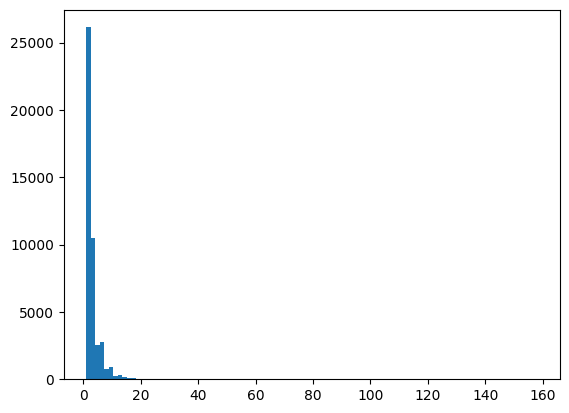

In [4]:
#整体情况
#从整体情况来看PV、UV、收藏、加购、购买，交易总数、交易用户比例、复购率和跳失率，用户流失分析

#总访问量pv
total_pv = clear_data['user_id'].count()
#总访客量UV
total_uv = clear_data['user_id'].nunique()
#日均访问量 = 总访问量/天数
avg_pv = round(total_pv/clear_data['date'].nunique(), 3)

#用户行为数据-用户量数据
#购买用户数量/付费用户数量
total_buy = clear_data[clear_data['behavior_type'] == 'buy']['user_id'].nunique()
#收藏用户量
total_fav = clear_data[clear_data['behavior_type'] == 'fav']['user_id'].nunique()
#加购用户量
total_cart = clear_data[clear_data['behavior_type'] == 'cart']['user_id'].nunique()

print("总访问量PV: {}".format(total_pv))
print("总访客量UV: {}".format(total_uv))
print("人均访问量: {}".format(round(total_pv/total_uv), 3))
print("日均访问量: {}".format(avg_pv))

print("购买用户量占比: {}".format(round(total_buy/total_uv, 3)))
print("收藏用户量占比: {}".format(round(total_fav/total_uv, 3)))
print("加购用户量占比: {}".format(round(total_cart/total_uv, 3)))

##付费相关指标

#付费率=付费人数/总人数
#人均购买次数 = 总购买次数/人数
#购买用户人均购买次数 = 总购买次数/购买用户数
#复购率 = 购买两次以上的人数/付费人数

pay_rate = round(clear_data[clear_data['behavior_type'] == 'buy']['user_id'].nunique()/total_uv, 2)
avg_buy =round(clear_data[clear_data['behavior_type'] == 'buy']['user_id'].count()/total_uv, 3)
avg_buy_con = round(clear_data[clear_data['behavior_type'] == 'buy']['user_id'].count()/clear_data[clear_data['behavior_type'] == 'buy']['user_id'].nunique(), 3)

buy_twice = clear_data[clear_data['behavior_type'] == 'buy'].groupby('user_id', as_index=False)['behavior_type'].count()
buy_twice.columns = ['user_id', 'buy_counts']
buy_twice = buy_twice[buy_twice['buy_counts'] >= 2]

print("人均购买次数: {}".format(avg_buy))
print("购买用户人均购买次数: {}".format(avg_buy_con))
print("购买率: {}".format(round(total_buy/total_uv, 3)))
print("复购率: {}".format(round(buy_twice['user_id'].nunique()/total_buy, 3)))


#跳失率
#跳失率 = 只有点击行为的用户/总用户数
user_type = clear_data.groupby('user_id').behavior_type.value_counts().unstack()
only_once_pv = user_type[user_type['pv'] == user_type.sum(axis=1)]
#sum(axis=1)对df进行横向相加，如果一个userid的pv值==横向相加的和，那就表明他只有点击行为
bounce_rate = only_once_pv.shape[0]/total_uv
print('跳失率: {:.2f}%'.format(bounce_rate*100))

#分析：
#跳失率为5.74%，数值看上去较小，但跳失率一定程度上反映了商品的受欢迎程度，
#可以对比下行业数据和以往数据分析是否处于正常范围
#影响跳失率的因素：商品吸引力，商品加载时长

#复购率：
#复购率达到68.2%，是一个较高的数值，进一步分析复购次数
import matplotlib.pyplot as plt

plt.figure()
plt.hist(user_type[user_type['buy']>=2]['buy']-1, bins=100)
plt.show()

#虽然复购率很高，但是进一步查看用户复购次数，发现绝大多数用户复购次数很少，
#推测，因为足够庞大的用户基数，导致足够的用户量复购一次也能提高复购率
#因此，在获取新用户的同事，促进老用户的复购次数增加，进一步稳定提高复购率应该是更重要的事情
#用户是否会复购，跟产品质量、服务、消费者的满意度有很强的相关性。

日访问量pv: date
2017-11-25    1044424
2017-11-26    1050975
2017-11-27     999290
2017-11-28     988747
2017-11-29    1029633
2017-11-30    1056450
2017-12-01    1113166
2017-12-02    1396290
2017-12-03    1199067
Name: user_id, dtype: int64
日访客量uv: date
2017-11-25    71360
2017-11-26    72247
2017-11-27    71777
2017-11-28    71890
2017-11-29    72891
2017-11-30    73954
2017-12-01    76302
2017-12-02    95432
2017-12-03    93002
Name: user_id, dtype: int64
人均日访问量: date
2017-11-25    14.636
2017-11-26    14.547
2017-11-27    13.922
2017-11-28    13.754
2017-11-29    14.126
2017-11-30    14.285
2017-12-01    14.589
2017-12-02    14.631
2017-12-03    12.893
Name: user_id, dtype: float64
日点击情况: date
2017-11-25     938571
2017-11-26     942005
2017-11-27     896196
2017-11-28     885760
2017-11-29     922295
2017-11-30     946981
2017-12-01     996631
2017-12-02    1249911
2017-12-03    1073740
Name: user_id, dtype: int64
日收藏情况: date
2017-11-25    29651
2017-11-26    30066
2017-11-27    2772

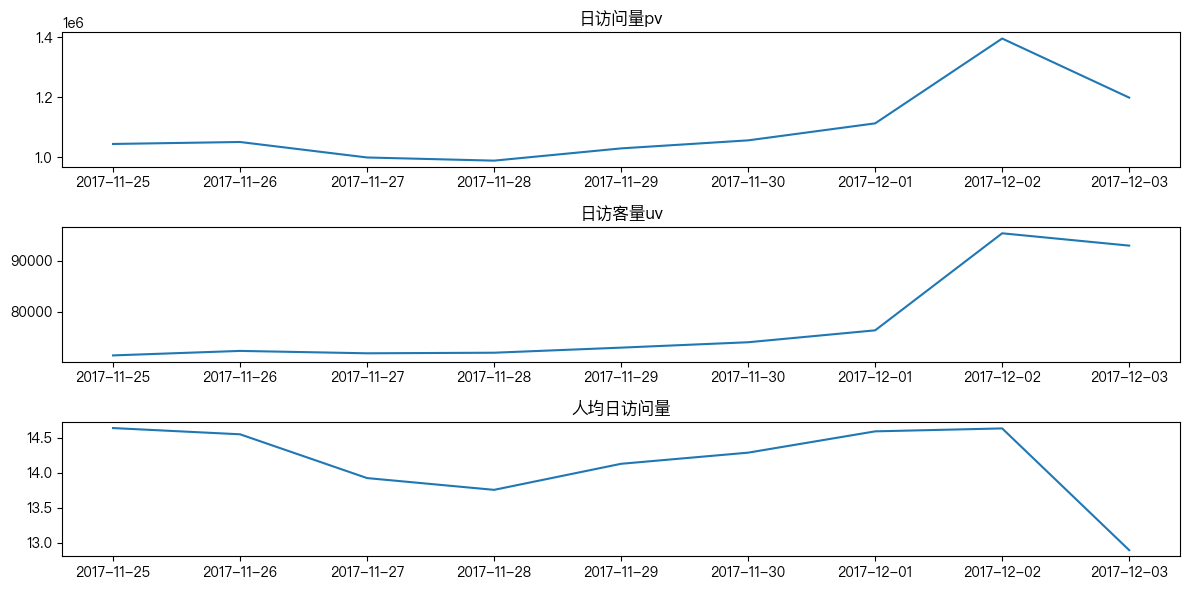

In [5]:
#日流量分析

#日访问量pv
daily_pv = clear_data.groupby('date')['user_id'].count()
print("日访问量pv: {}".format(daily_pv))
#日访客量
daily_uv = clear_data.groupby('date')['user_id'].nunique()
print("日访客量uv: {}".format(daily_uv))
#人均日访问量 = 访问量/访客数
daily_pv_uv = round(daily_pv/daily_uv, 3)
print("人均日访问量: {}".format(daily_pv_uv))

#日点击情况
daily_click = clear_data[clear_data['behavior_type'] == 'pv'].groupby('date')['user_id'].count()
print("日点击情况: {}".format(daily_click))
#日收藏情况
daily_fav = clear_data[clear_data['behavior_type'] == 'fav'].groupby('date')['user_id'].count()
print("日收藏情况: {}".format(daily_fav))
#日加购情况
daily_cart = clear_data[clear_data['behavior_type'] == 'cart'].groupby('date')['user_id'].count()
print("日加购情况: {}".format(daily_cart))
#日支付情况
daily_buy = clear_data[clear_data['behavior_type'] == 'buy'].groupby('date')['user_id'].count()
print("日支付情况: {}".format(daily_buy))

#构造一个新的dataframe存储日流量分析的数据
daily_data = pd.concat((daily_pv, daily_uv, daily_pv_uv, daily_click, daily_fav, daily_cart, daily_buy), axis=1)
daily_data.columns = ['daily_pv', 'daily_uv', 'daily_pv_uv', 'daily_click', 'daily_fav', 'daily_cart', 'daily_buy']

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['PingFang HK']

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(daily_data.index, daily_data['daily_pv'])
plt.title("日访问量pv")

plt.subplot(3, 1, 2)
plt.plot(daily_data.index, daily_data['daily_uv'])
plt.title("日访客量uv")

plt.subplot(3, 1, 3)
plt.plot(daily_data.index, daily_data['daily_pv_uv'])
plt.title("人均日访问量pv/uv")
plt.title("人均日访问量")

plt.tight_layout() #调整图中子图的大小，以便轴对象和轴上的标签不会重叠
plt.show()

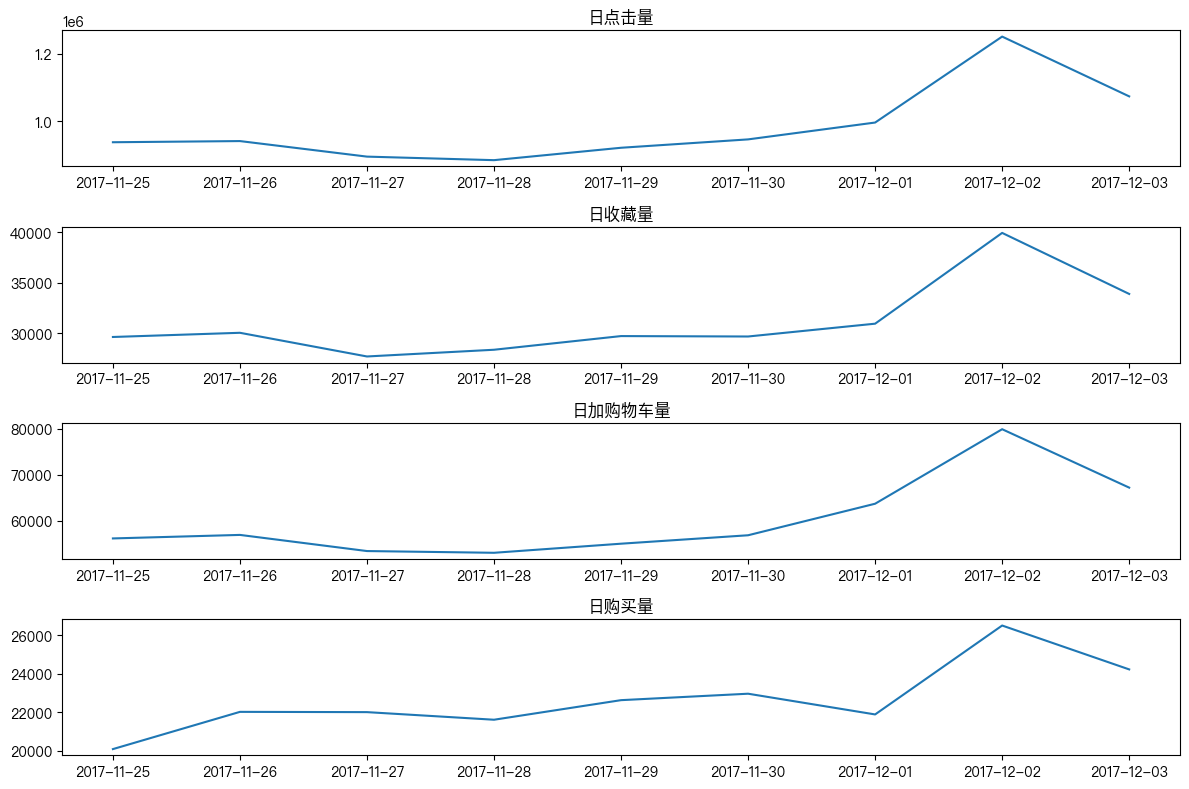

In [6]:
#用户日行为走势图
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(daily_data.index, daily_data['daily_click'])
plt.title('日点击量')

plt.subplot(4, 1, 2)
plt.plot(daily_data.index, daily_data['daily_fav'])
plt.title('日收藏量')

plt.subplot(4, 1, 3)
plt.plot(daily_data.index, daily_data['daily_cart'])
plt.title("日加购物车量")

plt.subplot(4, 1, 4)
plt.plot(daily_data.index, daily_data['daily_buy'])
plt.title('日购买量')

plt.tight_layout()
plt.show()


In [7]:
#时流量分析

#时均访问量pv
hour_pv = clear_data.groupby('hour')['user_id'].count()
print("时均访问量pv: {}".format(hour_pv))

#时均访客量
hour_uv = clear_data.groupby('hour')['user_id'].nunique()
print("时均访客量: {}".format(hour_uv))

#时均人均访客量
hour_pv_uv = round(hour_pv/hour_uv, 3)
print("时均访客量: {}".format(hour_pv_uv))

#时均点击、收藏、加购、购买
hour_click = clear_data[clear_data['behavior_type'] == 'pv'].groupby('hour')['user_id'].count()
hour_fav = clear_data[clear_data['behavior_type'] == 'fav'].groupby('hour')['user_id'].count()
hour_cart = clear_data[clear_data['behavior_type'] == 'cart'].groupby('hour')['user_id'].count()
hour_buy = clear_data[clear_data['behavior_type'] == 'buy'].groupby('hour')['user_id'].count()

#构建一个新的dataframe存储hourly数据
hourly_data = pd.concat((hour_pv, hour_uv, hour_pv_uv, hour_click, hour_fav, hour_cart, hour_buy), axis=1)
hourly_data.columns = ['hour_pv', 'hour_uv', 'hour_pv_uv', 'hour_click', 'hour_fav', 'hour_cart', 'hour_buy']



时均访问量pv: hour
00    337806
01    415513
02    486275
03    474092
04    476359
05    516069
06    520513
07    537245
08    512759
09    466822
10    476365
11    602875
12    728740
13    833484
14    828539
15    631269
16    310426
17    145165
18     80836
19     52411
20     46855
21     57968
22    121104
23    218552
Name: user_id, dtype: int64
时均访客量: hour
00    44973
01    52788
02    58329
03    59460
04    60071
05    60864
06    60128
07    61188
08    60523
09    59162
10    58842
11    63101
12    67201
13    69433
14    65948
15    52249
16    30586
17    16125
18     9477
19     6664
20     6094
21     7923
22    16785
23    31212
Name: user_id, dtype: int64
时均访客量: hour
00     7.511
01     7.871
02     8.337
03     7.973
04     7.930
05     8.479
06     8.657
07     8.780
08     8.472
09     7.891
10     8.096
11     9.554
12    10.844
13    12.004
14    12.564
15    12.082
16    10.149
17     9.002
18     8.530
19     7.865
20     7.689
21     7.316
22     7.215
23     

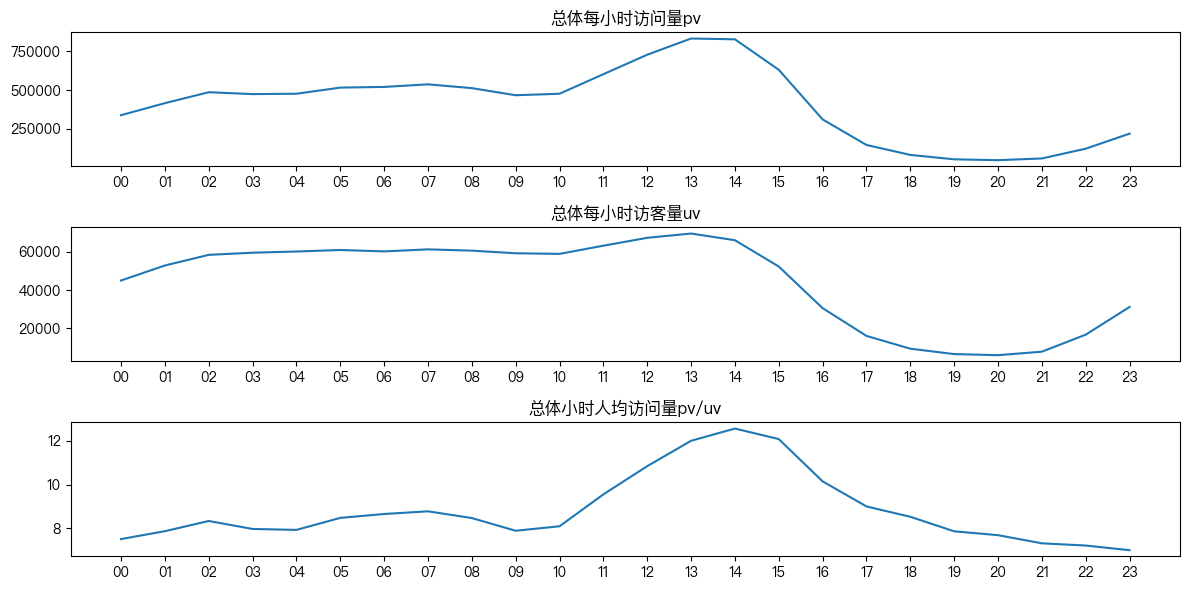

In [8]:
#绘图查看每个小时数据的变化趋势
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(hourly_data.index, hourly_data['hour_pv'])
plt.title("总体每小时访问量pv")

plt.subplot(3, 1, 2)
plt.plot(hourly_data.index, hourly_data['hour_uv'])
plt.title("总体每小时访客量uv")

plt.subplot(3, 1, 3)
plt.plot(hourly_data.index, hourly_data['hour_pv_uv'])
plt.title("总体小时人均访问量pv/uv")

plt.tight_layout() #调整图中子图的大小，以便轴对象和轴上的标签不会重叠
plt.show()

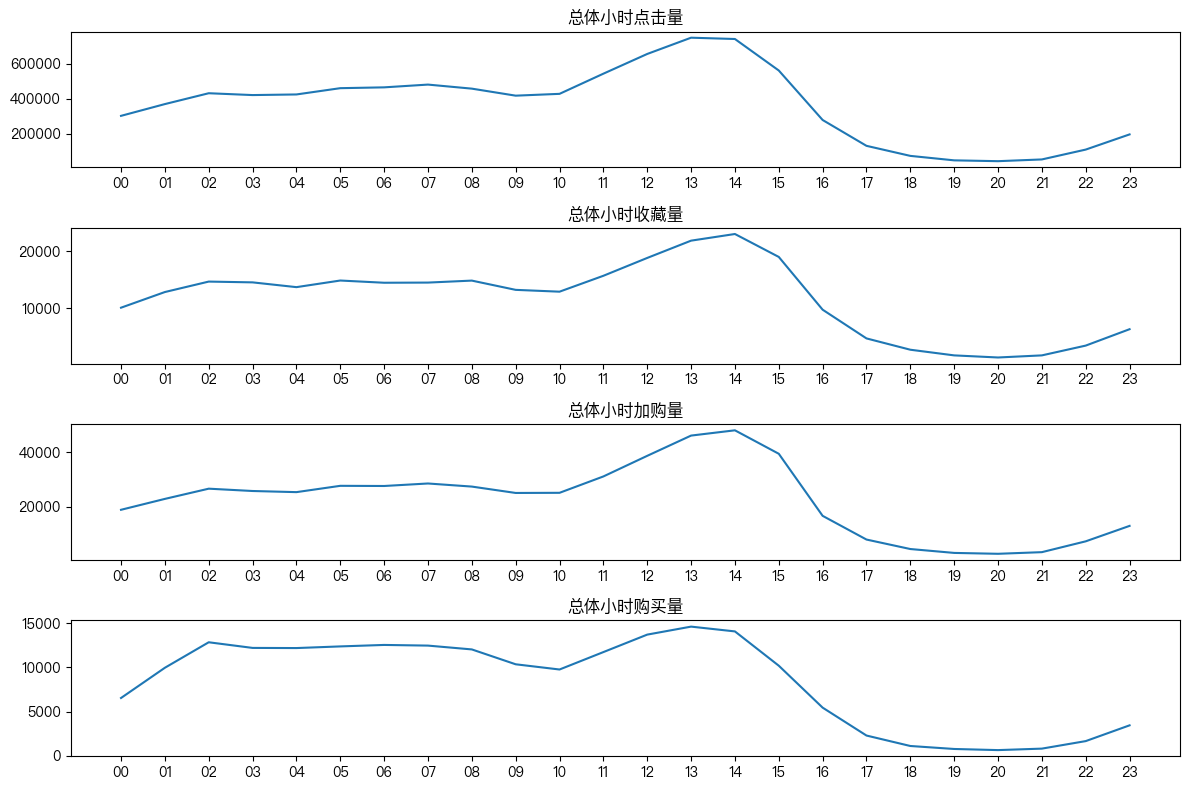

In [9]:
#整体小时用户行为
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(hourly_data.index, hourly_data['hour_click'])
plt.title('总体小时点击量')

plt.subplot(4, 1, 2)
plt.plot(hourly_data.index, hourly_data['hour_fav'])
plt.title('总体小时收藏量')

plt.subplot(4, 1, 3)
plt.plot(hourly_data.index, hourly_data['hour_cart'])
plt.title("总体小时加购量")

plt.subplot(4, 1, 4)
plt.plot(hourly_data.index, hourly_data['hour_buy'])
plt.title('总体小时购买量')

plt.tight_layout()
plt.show()


In [10]:
#用户行为变化趋势
#1.点击量、收藏量、购买量在2017年12/02号当天上升明显，经推测，应该是淘宝在12.02当天对“双十二”活动进行预热，开始商品精选活动，因此吸引了更多的点击量
#2.12.2号当天的指标优于其他时间段，说明活动有效
#3.各时段指标走势大致一致
#4.早上十点到下午2点是用户活跃度迅速增长的时段，2点以后用户又呈下降趋势。
#5.晚上20点以后，又呈一个上升趋势。

In [14]:
#用户维度分析

#用户转化率情况-流程漏斗分析
#分析两条路径：点击->收藏->购买； 点击->加购->购买
pv_df = clear_data[clear_data['behavior_type'] == 'pv']
buy_df = clear_data[clear_data['behavior_type'] == 'buy']
cart_df = clear_data[clear_data['behavior_type'] == 'cart']
fav_df = clear_data[clear_data['behavior_type'] == 'fav']

#process1: 点击->加购->购买
pv_cart_df = pd.merge(left=pv_df, right=cart_df, how='inner', on=['user_id', 'item_id', 'category_id'], suffixes=('_pv', '_cart'))
cart_buy_df = pd.merge(left=cart_df, right=buy_df, how='inner', on=['user_id', 'item_id', 'category_id'], suffixes=('_cart', '_buy'))

count_pv_cart = pv_cart_df[pv_cart_df.date_pv < pv_cart_df.date_cart].user_id.nunique()
count_cart_buy = cart_buy_df[cart_buy_df.date_cart < cart_buy_df.date_buy].user_id.nunique()

count_pv_cart
count_cart_buy

#process2 点击->收藏->购买
pv_fav_df = pd.merge(left=pv_df, right=fav_df, how='inner', on=['user_id', 'item_id', 'category_id'], suffixes=('_pv', '_fav'))
fav_buy_df = pd.merge(left=fav_df, right=buy_df, how='inner', on=['user_id', 'item_id', 'category_id'], suffixes=('_fav', '_buy'))
count_pv_fav = pv_fav_df[pv_fav_df.date_pv < pv_fav_df.date_fav].user_id.nunique()
count_fav_buy = fav_buy_df[fav_buy_df.date_fav < fav_buy_df.date_buy].user_id.nunique()

count_pv_fav
count_fav_buy

#计算转化率
fav_cart_ratio = (count_pv_fav + count_pv_cart)/total_uv
buy_ratio = (count_fav_buy + count_cart_buy)/total_uv
print("收藏/加购用户转化率为:%.2f%%" %(fav_cart_ratio * 100))
print("购买用户转化率:%.2f%%" %(buy_ratio * 100))


import plotly.graph_objs as go

idx = ['点击量', '收藏/加购量', '购买量']
data = [total_uv, count_pv_fav + count_pv_cart, count_fav_buy + count_cart_buy]
fig = go.Figure()
fig.add_trace(go.Funnel(name='ratio', y=idx, x=data, texttemplate="%{x}%"))
fig.update_layout(title = '用户路径转化率', dragmode=False)
fig.show(config={'displayModeBar': False})


收藏/加购用户转化率为:28.80%
购买用户转化率:19.33%


/var/folders/qs/ryw6f8mn2hlg37gpkg8sy2_40000gn/T/ipykernel_17907/1012602314.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



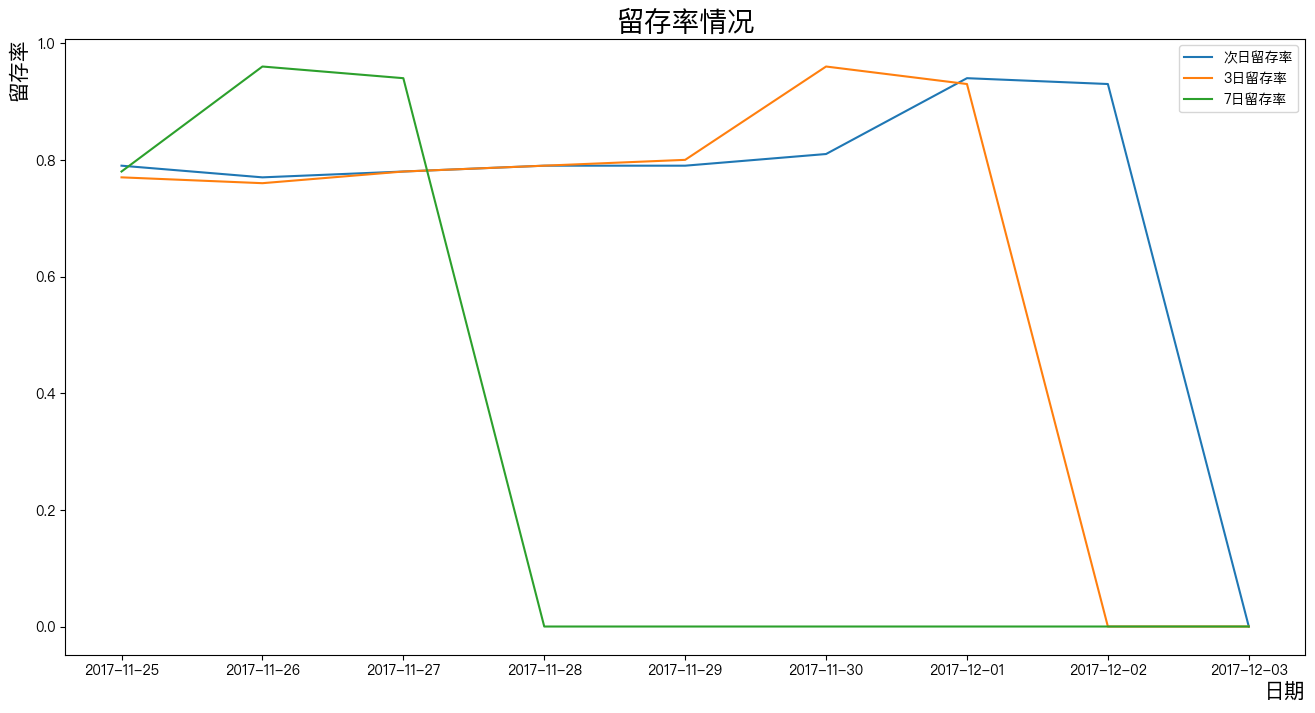

In [19]:
#用户留存率
#分析次日留存率、3日留存率、7日留存率、14日留存率、30日留存率,通过留存率分析平台的用户黏性
import datetime

data_retain = pd.DataFrame(columns=['日期', '基期用户数', '次日留存率', '3日留存率', '7日留存率', '14日留存率', '30日留存率'])
date_max = pd.Series(clear_data['date'].unique()).max()
#date_max += datetime.timedelta(days=1)
#date_max

for date in pd.Series(clear_data['date'].unique()).sort_values():
    data_retain_base = set(clear_data[clear_data['date']==date]['user_id'].unique())
    data_base_cnt = len(data_retain_base)

    data_retain_2days = len(set(clear_data[clear_data['date']==date+datetime.timedelta(days=1)]['user_id'].unique()) & data_retain_base)/data_base_cnt if date + datetime.timedelta(days=1)<=date_max else 0
    data_retain_3days = len(set(clear_data[clear_data['date'] == date+datetime.timedelta(days=2)]['user_id'].unique()) & data_retain_base)/data_base_cnt if date + datetime.timedelta(days=2)<=date_max else 0
    data_retain_7days = len(set(clear_data[clear_data['date'] == date + datetime.timedelta(days=6)]['user_id'].unique()) & data_retain_base)/data_base_cnt if date + datetime.timedelta(days=6)<=date_max else 0
    
    data_retain_dict = {'日期': [date], '基期用户数': [data_base_cnt], '次日留存率': [round(data_retain_2days, 2)], '3日留存率': [round(data_retain_3days, 2)], '7日留存率': [round(data_retain_7days, 2)]}
    data_retain_dict = pd.DataFrame(data_retain_dict)
    data_retain = pd.concat([data_retain, data_retain_dict], axis=0, join='inner')

data_retain.index=range(0, data_retain.shape[0])
data_retain

#留存率可视化
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_retain['日期'], data_retain['次日留存率'], label='次日留存率')
ax.plot(data_retain['日期'], data_retain['3日留存率'], label='3日留存率')
ax.plot(data_retain['日期'], data_retain['7日留存率'], label='7日留存率')
#ax.plot(data_retain['日期'], data_retain['14日留存率'], label='14日留存率')
#ax.plot(data_retain['日期'], data_retain['30日留存率'], label='30日留存率')

ax.set_xlabel('日期', size=15, loc='right')
ax.set_ylabel('留存率', size=15, loc='top')
ax.set_title('留存率情况', size=20)

ax.legend()
plt.show()

购买次数前10的客户:
 user_id
702034    159
834051     69
9610       67
754360     66
549770     66
615000     63
614583     58
675514     56
99904      55
858271     53
Name: behavior_type, dtype: int64
用户购买次数分布表:
 behavior_type
1      23510
2      15953
3      10184
4       6386
5       4072
6       2571
7       1669
8       1093
9        790
10       520
11       396
12       245
13       226
14       124
15       115
16        79
17        74
18        49
19        35
20        39
21        29
22        16
23        19
24        12
25        13
26        16
27        13
28         8
29         5
30         5
31         1
32         8
33         3
34         6
35         1
36         3
37         2
38         2
39         1
40         1
41         4
42         1
43         1
51         1
53         1
55         1
56         1
58         1
63         1
66         2
67         1
69         1
159        1
Name: behavior_type, dtype: int64


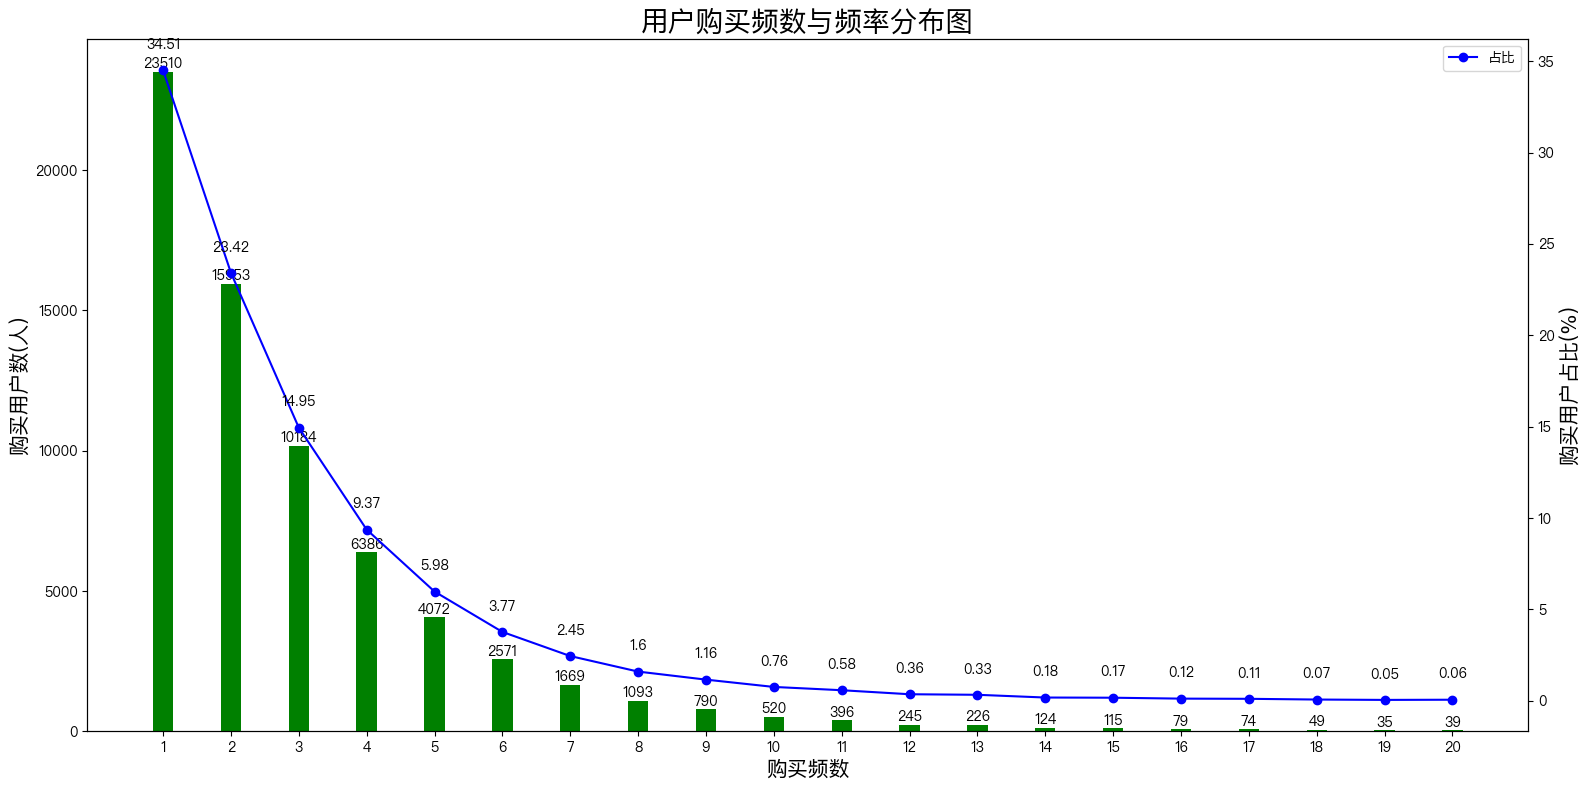

In [18]:
#用户购买量

#购买次数前10的客户
top10_user = clear_data[clear_data['behavior_type'] == 'buy'].groupby('user_id')['behavior_type'].count()
print("购买次数前10的客户:\n {}".format(top10_user.sort_values(ascending=False).head(10)))

#用户购买频数与频率分布图
top10_user_distribution = top10_user.groupby(top10_user).count()
print("用户购买次数分布表:\n {}".format(top10_user_distribution))


#画图展示用户购买频数分布图
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx() #产生ax1的镜面坐标

xticks = pd.Series(top10_user_distribution.head(20).index)
xticks = xticks.map(lambda s: str(s)).to_list()

yticks_1 = list(top10_user_distribution.head(20))
yticks_2 = list(round(top10_user_distribution.head(20)/top10_user_distribution.head(20).sum()*100, 2))

ax1.bar(xticks, yticks_1, width=0.3, color='g', label=u'人数')
for a, b in zip(xticks, yticks_1):
    ax1.text(a, b+20, b, ha='center', va='bottom')

ax2.plot(xticks, yticks_2, marker = 'o', color='b', label=u'占比')
for a, b in zip(xticks, yticks_2):
    ax2.text(a, b+1, b, ha='center', va='bottom')

ax1.set_xlabel("购买频数", size=15)
ax1.set_ylabel("购买用户数(人)", size=15)
ax2.set_ylabel("购买用户占比(%)", size=15)

plt.title("用户购买频数与频率分布图", size=20)
plt.tight_layout()
plt.legend()
plt.show()

In [52]:
#用户RFM价值分析
#RFM模型通过一个客户的近期购买行为，购买的总体频率以及花了多少钱这3项指标来描述该客户的价值状况
#R：客户最近一次交易的时间间隔。R越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
#F：客户在最近一段时间内交易的次数。F越大，表示交易越频繁，反之，则表示客户交易不够活跃。
#M：客户在最近一段时间内交易的金额。M越大，表示客户价值越高，反之，则表示客户价值越低。
#该数据集不包含金额，仅从R、F两个维度进行分析

#R
clear_data.head()
groupby_buy_userid = clear_data[clear_data['behavior_type']=='buy'].groupby('user_id')
RF = pd.DataFrame(index=groupby_buy_userid.groups.keys(), columns=['R', 'F'])

RF['F'] = groupby_buy_userid.behavior_type.count()
RF['last_buy_date'] = groupby_buy_userid.date.max()
#我们以2017-12-4为对照日期，保留天数
RF['R'] = (pd.to_datetime('2017-12-04') - RF['last_buy_date']).dt.days

RF[['R', 'F']].describe()
#最近的一次交易记录在2017/12/3号，距离12-4号只有一天
#最久的一次交易记录在9天前，平均为3天
#R我们划分4个区间1-2，3-4， 5-6，7-9分别得分4， 3， 2， 1
#交易次数最少为1次，最多为195次，平均2次
#F划分4个区域1， 2， 3， 4+ 分别得分为1，2， 3， 4

def R_score(r):
    if r>=1 and r<2:
        return 4
    elif r>=3 and r<=4:
        return 3
    elif r>=5 and r<=6:
        return 2
    elif r>=7 and r<=9:
        return 1
    else:
        return 0
    
def F_score(f):
    if f == 1:
        return 1
    elif f == 2:
        return 2
    elif f == 3:
        return 3
    elif f >= 4:
        return 4
    else:
        return 0
    
RF['R_SCORE'] = RF.R.map(R_score)
RF['F_SCORE'] = RF.F.map(F_score)

RF['R>mean?'] = (RF['R_SCORE'] > RF['R_SCORE'].mean())*1
RF['F>mean?'] = (RF['F_SCORE'] > RF['F_SCORE'].mean())*1

def user_classifcation(tup):
    r_score, f_score = tup
    if r_score == 0 and f_score ==1:
        return "重要保持客户"
    elif r_score == 1 and f_score == 0:
        return "重要发展客户"
    elif r_score == 1 and f_score == 1:
        return "重要价值客户"
    elif r_score == 0 and f_score == 0:
        return "重要挽留用户"
    else:
        return "无价值"


RF['user_classification'] = RF.iloc[:,5:7].apply(user_classifcation, axis=1)
RF['user_classification'].value_counts()
#牛逼啊，第一次用这种方式
RF['user_classification'].value_counts(1)

user_classification
重要挽留用户    0.348875
重要价值客户    0.246871
重要发展客户    0.228821
重要保持客户    0.175433
Name: proportion, dtype: float64

In [55]:
#商品维度
#商品数量与商品类别数量
print("商品数目: {}".format(clear_data['item_id'].nunique()))
print("商品类别数目: {}".format(clear_data['category_id'].nunique()))

#top10商品分析
#商品分析主要从点击、收藏、加购、购买等4个角度分析，
#通过点击量可以看出商品是否对用户具有吸引力
#通过购买量可以看出用户对商品的需求
#通过统计商品的点击->购买率，可以看出商品点击流量的转哈情况

#购买量top10的商品的分析
top10_buy_item = clear_data[clear_data['behavior_type'] == 'buy'].groupby('item_id')['user_id'].count().sort_values(ascending=False).head(10)
print("购买量top10的商品:\n {}".format(top10_buy_item))

#点击量top10的商品分析
top10_click_item = clear_data[clear_data['behavior_type'] == 'pv'].groupby('item_id')['user_id'].count().sort_values(ascending=False).head(10)
print("点击量top10的商品:\n {}".format(top10_click_item))

#top10商品类别分析
top10_buy_category = clear_data[clear_data['behavior_type'] == 'buy'].groupby('category_id')['user_id'].count().sort_values(ascending=False).head(10)
print("购买量top10的商品类别:\n {}".format(top10_buy_category))

商品数目: 1608520
商品类别数目: 8111
购买量top10的商品:
 item_id
3122135    158
3031354     79
3964583     75
2560262     74
1415828     64
1910706     64
740947      59
4443059     59
2964774     56
1034594     56
Name: user_id, dtype: int64
点击量top10的商品:
 item_id
812879     2997
3845720    2520
138964     2146
2331370    1903
59883      1821
3371523    1785
1535294    1771
2032668    1714
2367945    1702
1591862    1700
Name: user_id, dtype: int64
购买量top10的商品类别:
 category_id
1464116    3436
2735466    3224
2885642    3215
4145813    3101
4801426    2607
4756105    2571
982926     2468
2640118    1905
4159072    1904
1320293    1704
Name: user_id, dtype: int64


In [56]:
#帕累托分析
#对商品和商品类别进行帕累托分析，找出贡献前80%销量的商品类别和商品，往往这些商品类别和商品占总体的比重不到20%，可以将运营推广的重点放在这部分商品类别和商品中

#类别分析
top10_buy_category2 = pd.DataFrame()
top10_buy_category2['cate_buy_num'] = clear_data[clear_data['behavior_type']=='buy'].groupby('category_id')['category_id'].count().sort_values(ascending=False)
top10_buy_category2['cate_comsum'] =  top10_buy_category2['cate_buy_num'].expanding().sum()

max_num = top10_buy_category2['cate_comsum'].max()

cate_80percent_cumsom = top10_buy_category2[top10_buy_category2['cate_comsum']/max_num < 0.8]['cate_comsum'].count()
print("贡献前百分之八十销量的类型总数为:{}".format(cate_80percent_cumsom))
rate = cate_80percent_cumsom/clear_data['category_id'].nunique()
print("贡献前百分之八十销量的类别占比: {}".format(round(rate, 3)))

贡献前百分之八十销量的类型总数为:716
贡献前百分之八十销量的类别占比: 0.088


In [57]:
#商品分析
top10_buy_item = pd.DataFrame()
top10_buy_item['item_buy_num'] = clear_data[clear_data['behavior_type']=='buy'].groupby('item_id')['item_id'].count().sort_values(ascending=False)
top10_buy_item['item_comsum'] = top10_buy_item['item_buy_num'].expanding().sum()

max_num = top10_buy_category2['cate_comsum'].max()

item_80percent_comsum = top10_buy_item[top10_buy_item['item_buy_num']/max_num < 80]['item_buy_num'].count()
print("贡献前百分之八十销量的产品总数为: {}".format(item_80percent_comsum))
rate = item_80percent_comsum/clear_data['item_id'].nunique()
print("贡献前百分之八十的销量的商品占比为: {}".format(round(rate, 3)))

贡献前百分之八十销量的产品总数为: 130343
贡献前百分之八十的销量的商品占比为: 0.081
